<b>Problem Statement</b><br>
I decided to treat this as a classification problem by creating a new binary<br>
variable affair (did the woman have at least one affair?) and trying to<br>
predict the classification for each woman.<br>
<b>Dataset</b>
The dataset I chose is the affairs dataset that comes with Statsmodels.<br>
It was derived from a survey of women in 1974 by Redbook magazine, in<br>
which married women were asked about their participation in extramarital affairs.<br>
More information about the study is available in a 1978 paper from <br>
the Journal of Political Economy.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.model_selection import cross_val_score

Data preprocessing

In [2]:
#load dataset
affairdata = sm.datasets.fair.load_pandas().data

In [3]:
affairdata.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [4]:
#add "affair" column: 1 represents having affairs, 0 represents not
affairdata['affair'] = (affairdata.affairs > 0).astype(int)
affairdata.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


Data Exploration

In [5]:
affairdata.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


We can see that on average, women who have affairs rate their marriages lower, which is to be expected. 

In [6]:
#check rate_marriage variable
affairdata.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


 It seems an increase in age, yrs_married, and children appears to correlate with a declining marriage rating.

<b>Data Visualization</b>

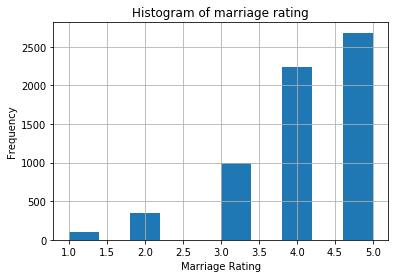

In [6]:
#histogram of marriage rating
affairdata.rate_marriage.hist()
plt.title('Histogram of marriage rating');
plt.xlabel('Marriage Rating');
plt.ylabel('Frequency');

There are more women who have given the rating of 5 in the sample

Text(0, 0.5, 'Frequency')

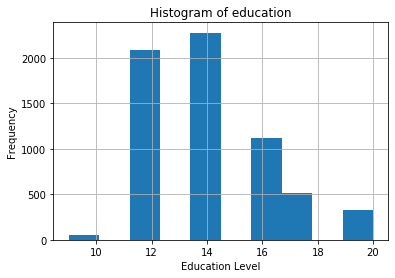

In [7]:
#histogram of education rating
affairdata.educ.hist()
plt.title('Histogram of education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

The highest education level in the sample is 14 i.e some college. And there is a decline in education level after college.

Distribution of marriage ratings for those having affairs versus those not having affairs.

Text(0, 0.5, 'Frequency')

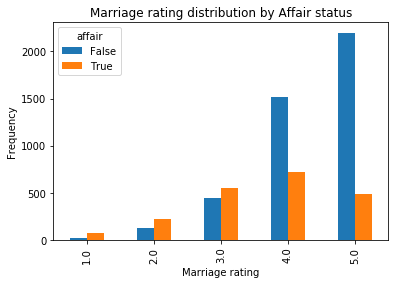

In [8]:
#barplot of marriage rating group after affair
pd.crosstab(affairdata.rate_marriage, affairdata.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage rating distribution by Affair status')
plt.xlabel('Marriage rating')
plt.ylabel('Frequency')

Let's use a stacked barplot to look at the percentage of women having affairs by number of years of marriage.

Text(0, 0.5, 'Percentage')

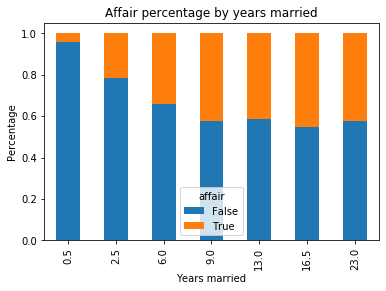

In [9]:
affairs_yrs_married = pd.crosstab(affairdata.yrs_married, affairdata.affair.astype(bool))
affairs_yrs_married.div(affairs_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked = True)
plt.title('Affair percentage by years married')
plt.xlabel('Years married')
plt.ylabel('Percentage')

<b>Prepare Data for Logistic Regression-</b><br>
To prepare the data, we will add an intercept column as well as dummy variables for occupation and occupation_husb, since we are treating them as categorial variables.<br> 
The dmatrices function from the patsy module can do that using formula language

In [10]:
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + religious + educ + C(occupation) + C(occupation_husb)', affairdata, return_type="dataframe")
print(X.columns)

Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')


The column names for the dummy variables are ugly, so let's rename those-

In [11]:
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4', 
                        'C(occupation)[T.5.0]':'occ_5', 
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2', 
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4', 
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})
print(X.columns)

Index(['Intercept', 'occ_2', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_husb_2',
       'occ_husb_3', 'occ_husb_4', 'occ_husb_5', 'occ_husb_6', 'rate_marriage',
       'age', 'yrs_married', 'children', 'religious', 'educ'],
      dtype='object')


We also need to flatten y into a 1-D array, so that scikit-learn will properly understand it as the response variable

In [12]:
#flatten y into a 1-D array
y = np.ravel(y)

Logistic Regression-

In [19]:
"""Standardization refers to shifting the distribution of each attribute
to have a mean of zero and a standard deviation of one (unit variance). 
It is useful to standardize attributes for a model that relies on the 
distribution of attributes such as Gaussian processes.
"""
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)

#instantiate a logistic regression model, and fit with Xscaled and y

model = LogisticRegression()
model = model.fit(X_scaled,y)

#check the accuracy on the training set
model.score(X_scaled,y)

0.7260446120012567

73% accuracy seems good, but what's the null error rate?

In [16]:
#what percentage had affairs?
y.mean()

0.3224945020420987

Only 32% of the women had affairs, which means that we could obtain 68% accuracy by always predicting "no".<br>
Let's examine the coefficients to see what we learn-

In [26]:
#examine the coefficients
pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))

,0,1
0,Intercept,[0.0]
1,occ_2,[0.10803435046533442]
2,occ_3,[0.3118951883303905]
3,occ_4,[0.1800157251556634]
4,occ_5,[0.3140080284085002]
5,occ_6,[0.13409897690852474]
6,occ_husb_2,[0.06797617897145544]
7,occ_husb_3,[0.07499877581255965]
8,occ_husb_4,[0.0656188054647243]
9,occ_husb_5,[0.07633037526602976]


From the above output we can say-Increases in marriage rating, age, educ and religiousness correspond to a decrease in the likelihood of having an affair. 

<b>Model Evaluation Using a Validation Set-</b><br>
So far, we have trained and tested on the same set. Let's instead split the data into a training set and a testing set.


In [31]:
#evaluate model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

#standardize the data
X_scaled_train = preprocessing.scale(X_train)

model2 = LogisticRegression()
model2.fit(X_scaled_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
#predict class labels for the test set
predicted = model2.predict(preprocessing.scale(X_test))
print(predicted)

[1. 0. 0. ... 0. 0. 0.]


In [35]:
#generate class probabilities
probs = model2.predict_proba(preprocessing.scale(X_test))
print(probs)

[[0.35179113 0.64820887]
 [0.91168716 0.08831284]
 [0.72619303 0.27380697]
 ...
 [0.56348343 0.43651657]
 [0.80843405 0.19156595]
 [0.75060994 0.24939006]]


As you can see, the classifier is predicting a 1 (having an affair) any time the probability in the second column is greater than 0.5.

In [38]:
#generate evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:,1]))

0.731413612565445
0.7457533685412323


The accuracy is 73%, which is the same as we experienced when training and predicting on the same data.

In [39]:
#confusion matrix
print(metrics.confusion_matrix(y_test, predicted))

#print classification report
print(metrics.classification_report(y_test, predicted))

[[1171  132]
 [ 381  226]]
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82      1303
         1.0       0.63      0.37      0.47       607

    accuracy                           0.73      1910
   macro avg       0.69      0.64      0.64      1910
weighted avg       0.72      0.73      0.71      1910



<b>Model Evaluation Using Cross-Validation-</b>

In [42]:
#evaluate model using 10 fold cross validation
scores = cross_val_score(LogisticRegression(), X_scaled, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[0.71899529 0.70172684 0.73783359 0.70643642 0.70486656 0.7299843
 0.72955975 0.70597484 0.75471698 0.74685535]
0.7236949932367722


Looks good. It's still performing at 73% accuracy.So our model is ready for prediction!


<b>Can we predict the probability of an affair using our model?</b><br>
Let's predict the probability of an affair for a random woman not present in the dataset. 
Assume she's a 25-year-old house wife who graduated college, has been married for 3 years, has 1 child, rates herself as strongly religious, rates her marriage as fair, and her husband is a farmer.


In [54]:
model.predict_proba(preprocessing.scale((np.array([[1,0,0,1,0,0,1,0,0,0,0,3,25,3,1,4,16]]))))

array([[0.70418924, 0.29581076]])



The predicted probability of an affair is 29%.
